# Overview

This analysis focuses on using clustering to analyze time series of business establishment across NYC using historical US Census data. The data provide insights from 1994 - 2014.

Key clustering techniques used includes data whitening, K-Means, and Agglomerative Clustering.

---
## 1. Data Download


In [354]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pylab as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import time
import os
import zipfile 
from urllib.request import urlretrieve
from IPython.display import display, clear_output
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Ian/anaconda/envs/python36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [355]:
def download(file_path, url_path):
    '''
    This script checks if the file exists; download if not.
    Input: path of the file, url to download
    Return: None
    '''
    if os.path.isfile(file_path) is True: 
            print("File Already Exists at {}. Skip.".format(file_path))
            pass
    else: 
        print("Downloading Data from {}".format(url_path))
        urlretrieve(url_path, file_path)

def unzip(file_path):
    '''
    This script checks if unzip files exists; unzip if not.
    Input: path of the file
    Return: None
    '''

    if os.path.isfile("./data/ZIP_CODE_040114.shp") is False:
        !unzip $file_path -d ./data
    else: 
        print("File already exists. Skip Unzipping.")
        
def datadownlaod():
    
    '''
    This function set up the folder and downloads and extract data from US Census for the analysis
    Input: none
    Return: none; it updates the folder structure and creates new data if not exist
    '''
    
    # Create a data file if not exists
    if os.path.isdir("./raw_data") is False:
        !mkdir raw_data
    if os.path.isdir("./data") is False:
        !mkdir data
    else:
        print("Data Folders Already Exists. Pass.")
    
    # Download US Census Files
    print("--- Start --- ")
    for year in range(94, 115):
        
        if year < 100:
            file_path = "./data/census_" + str(year) + ".zip"
            url_path = "https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp"+ str(year) + "totals.zip"
        
        elif 101 < year < 110:
            file_path = "./data/census_" + str(year) + ".zip"
            url_path = "https://www2.census.gov/econ200" + str(year-100) + "/CBP_CSV/zbp0" + str(year-100) + "totals.zip"
        
        elif year >= 110:
            file_path = "./data/census_" + str(year) + ".zip"
            url_path = "https://www2.census.gov/econ20" + str(year-100) + "/CBP_CSV/zbp" + str(year-100) + "totals.zip"
        
        else: 
            file_path = "./data/census_" + str(year) + ".zip"
            url_path = "https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0"+ str(year-100) + "totals.zip"
        
        download(file_path, url_path)
    
    # Download ZipCode Shapefile
    download("./data/Zip_Shape.zip", "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip")
    unzip("./data/Zip_Shape.zip")
    print("--- Done --- ")
    
datadownlaod()

Data Folders Already Exists. Pass.
--- Start --- 
File Already Exists at ./data/census_94.zip. Skip.
File Already Exists at ./data/census_95.zip. Skip.
File Already Exists at ./data/census_96.zip. Skip.
File Already Exists at ./data/census_97.zip. Skip.
File Already Exists at ./data/census_98.zip. Skip.
File Already Exists at ./data/census_99.zip. Skip.
File Already Exists at ./data/census_100.zip. Skip.
File Already Exists at ./data/census_101.zip. Skip.
File Already Exists at ./data/census_102.zip. Skip.
File Already Exists at ./data/census_103.zip. Skip.
File Already Exists at ./data/census_104.zip. Skip.
File Already Exists at ./data/census_105.zip. Skip.
File Already Exists at ./data/census_106.zip. Skip.
File Already Exists at ./data/census_107.zip. Skip.
File Already Exists at ./data/census_108.zip. Skip.
File Already Exists at ./data/census_109.zip. Skip.
File Already Exists at ./data/census_110.zip. Skip.
File Already Exists at ./data/census_111.zip. Skip.
File Already Exists 

In [356]:
zipcode = gpd.read_file("./data/ZIP_CODE_040114.shp")
zipcode["ZIPCODE"] = zipcode["ZIPCODE"].astype(int)
zipcode.dtypes

ZIPCODE         int64
BLDGZIP        object
PO_NAME        object
POPULATION    float64
AREA          float64
STATE          object
COUNTY         object
ST_FIPS        object
CTY_FIPS       object
URL            object
SHAPE_AREA    float64
SHAPE_LEN     float64
geometry       object
dtype: object

---

## 2. Prepare Data

- integrate datasets
- whiten time series data

In [357]:
# Create a joined dataset of Establishment from 1994 - 2014

def joinData(dir_path, left_df):
    
    '''
    This function iterate through zip files, concatenate Establishment by year, return the joined dataset
    Input: directory of the files, left-hand-side file
    Return: Data Frame
    '''
    
    try: 
        for year in range(94, 115):
            
            # Read and join establishment column from each year; also clean column names
            print("merging data from year: {}".format(year))
            
            file_name = "census_" + str(year) + ".zip"
            new_df = pd.read_csv(dir_path + file_name, compression="zip")
            
            # Clean up yearly census metadata before joining
            new_df.columns = [col.lower() for col in new_df.columns]
            new_df = new_df[["zip", "est"]]
            new_df['zip'] = new_df['zip'].astype(int)
            
            # Join
            left_df = left_df.merge(new_df, how = "left", left_on = "ZIPCODE", right_on = "zip").drop('zip', axis = 1)
            left_df.columns.values[-1] = "est_" + str(year)
            del new_df
    
        print("--- DONE ---")
    
    except Exception as ex:
        print(ex)
        print("--- NOT COMPLETE ---")
        pass
    
    return left_df

join_df = joinData("./data/", zipcode)

merging data from year: 94
merging data from year: 95
merging data from year: 96
merging data from year: 97
merging data from year: 98
merging data from year: 99
merging data from year: 100
merging data from year: 101
merging data from year: 102
merging data from year: 103
merging data from year: 104
merging data from year: 105
merging data from year: 106
merging data from year: 107
merging data from year: 108
merging data from year: 109
merging data from year: 110
merging data from year: 111
merging data from year: 112
merging data from year: 113
merging data from year: 114
--- DONE ---


In [358]:
df_94 = pd.read_csv("./data/census_94.zip", compression = "zip")

In [359]:
join_df.head(10)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,est_105,est_106,est_107,est_108,est_109,est_110,est_111,est_112,est_113,est_114
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0
5,11226,0,Brooklyn,106132.0,3.940860e+07,NY,Kings,36,047,http://www.usps.com/,...,1049.0,1015.0,1049.0,1083.0,1097.0,1127.0,1169.0,1229.0,1256.0,1283.0
6,11219,0,Brooklyn,92561.0,4.200274e+07,NY,Kings,36,047,http://www.usps.com/,...,2343.0,2351.0,2391.0,2396.0,2487.0,2581.0,2647.0,2696.0,2777.0,2882.0
7,11210,0,Brooklyn,67067.0,4.788702e+07,NY,Kings,36,047,http://www.usps.com/,...,875.0,893.0,887.0,906.0,919.0,990.0,1030.0,1006.0,1003.0,1026.0
8,11230,0,Brooklyn,80857.0,4.992670e+07,NY,Kings,36,047,http://www.usps.com/,...,1930.0,1934.0,1934.0,1945.0,1984.0,2026.0,2062.0,1999.0,2095.0,2150.0
9,11204,0,Brooklyn,77354.0,4.355518e+07,NY,Kings,36,047,http://www.usps.com/,...,1778.0,1806.0,1858.0,1826.0,1817.0,1902.0,1960.0,2024.0,2108.0,2205.0


In [360]:
join_df.shape

(263, 34)

In [361]:
# Drop any row with NA to ensure data availability

join_df = join_df.dropna()
join_df.shape

(243, 34)

In [362]:
# Drop duplicated zipcodes

join_df = join_df.drop_duplicates(subset = "ZIPCODE")
join_df.shape

(230, 34)


## Whiten Time Series Data

In [363]:
features = ["est_"+str(year) for year in range(94, 115)]

whiten_df = pd.concat([join_df['ZIPCODE'], join_df[features]], axis = 1)\
            .set_index("ZIPCODE")

In [364]:
whiten_df.shape

(230, 21)

In [365]:
whiten_df.head()

,est_94,est_95,est_96,est_97,est_98,est_99,est_100,est_101,est_102,est_103,...,est_105,est_106,est_107,est_108,est_109,est_110,est_111,est_112,est_113,est_114
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [366]:
whiten_df = ((whiten_df.T - whiten_df.mean(axis=1)) / whiten_df.std(axis=1)).T

In [367]:
# Sanity Check
for idx in range(0, 10):
    data = whiten_df.iloc[idx]
    print("STDED for ZIP {} : {:.3f}".format(data.name, data.std()))
    print("MEAN for ZIP {} : {:.3f}".format(data.name, data.mean()))

STDED for ZIP 11436 : 1.000
MEAN for ZIP 11436 : -0.000
STDED for ZIP 11213 : 1.000
MEAN for ZIP 11213 : -0.000
STDED for ZIP 11212 : 1.000
MEAN for ZIP 11212 : 0.000
STDED for ZIP 11225 : 1.000
MEAN for ZIP 11225 : -0.000
STDED for ZIP 11218 : 1.000
MEAN for ZIP 11218 : -0.000
STDED for ZIP 11226 : 1.000
MEAN for ZIP 11226 : 0.000
STDED for ZIP 11219 : 1.000
MEAN for ZIP 11219 : -0.000
STDED for ZIP 11210 : 1.000
MEAN for ZIP 11210 : -0.000
STDED for ZIP 11230 : 1.000
MEAN for ZIP 11230 : 0.000
STDED for ZIP 11204 : 1.000
MEAN for ZIP 11204 : 0.000


--- 

## 3. Cluster Yearly Establishment (1994 - 2014) using K-Means and Agglomerative Clustering

In [368]:
# Analyze Silhouette Score of k from 2 to 8
init = 100
seed= 123
from sklearn.metrics import silhouette_samples, silhouette_score

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=init)
    km_group = kmeans.fit_predict(whiten_df)
    print("K = {} | Silhouette Score = {}".format(k, silhouette_score(whiten_df, km_group)))

K = 2 | Silhouette Score = 0.5724983348020769
K = 3 | Silhouette Score = 0.5179510293705382
K = 4 | Silhouette Score = 0.4931292363682341
K = 5 | Silhouette Score = 0.25143478594468277
K = 6 | Silhouette Score = 0.2648128084088309
K = 7 | Silhouette Score = 0.22532108465341782
K = 8 | Silhouette Score = 0.1460164814219695


### Discussion

Based on the Silhouette Score, the best number of cluster is 2 because it has the highest Silhouette Score. For visualization purposes, I will pick k = 4 so there are more cluster to analyze without trading off too much performance. k = 5 has sharp drop off of Silhouette Score

In [392]:
def run_clustering(n):
    '''
    This function runs k-mean and agglorative clustering using a user specified cluster number.
    Input: number of clusters
    Return: None; it creates km and agc lables (km_group, agc_group) 
            respectively in the model dataset
    '''
    
    # Use K-Mean
    kmeans = KMeans(n_clusters=n, random_state=seed, n_init=init)
    whiten_df["km_group"] = kmeans.fit_predict(whiten_df)
    
    # Use Agglomerative Clustering
    agc = AgglomerativeClustering(n_clusters=n,  compute_full_tree=True)
    whiten_df["agc_group"] = agc.fit_predict(whiten_df)
    
    print("--- K Mean Cluster Size ---")
    print(whiten_df.groupby("km_group").size())
    
    print("--- Agglomerative Cluster Size ---")
    print(whiten_df.groupby("agc_group").size())    

def plot_clusters(cluster_name, n):
    
    '''
    This function plots the time series clusters.
    Input: the label name (i.e. 'km_group' or 'agc_group')
    Return: None; it shows the plots.
    '''
    
    fig = plt.figure(figsize = (16, 16));
    fig.subplots_adjust(hspace = 0.15*n)
    try:
        # Plot Time Series in Each Sample 
        for k in range(0, n):
            data = whiten_df[whiten_df[cluster_name] ==k][features];
            position = str(n)+"1"+str(k+1)
            fig.add_subplot(int(position));

            for row in range(0, data.shape[0]):
                plt.title("{}: {}".format(cluster_name, k))
                plt.plot([year for year in range(1994, 2015)], data.iloc[row, :], alpha = 0.6, c = "grey")

            cluster_mean = [data.iloc[:, col].mean() for col in range(0, data.shape[1])]
            plt.plot([year for year in range(1994, 2015)], cluster_mean, c = "black")
    except Exception as ex:
        
        print(ex)
        print('--- NOT COMPLETED ---')

In [393]:
run_clustering(4)

--- K Mean Cluster Size ---
km_group
0    123
1     39
2     50
3     18
dtype: int64
--- Agglomerative Cluster Size ---
agc_group
0     46
1     46
2     15
3    123
dtype: int64


--- 

## 4. Visual Analysis

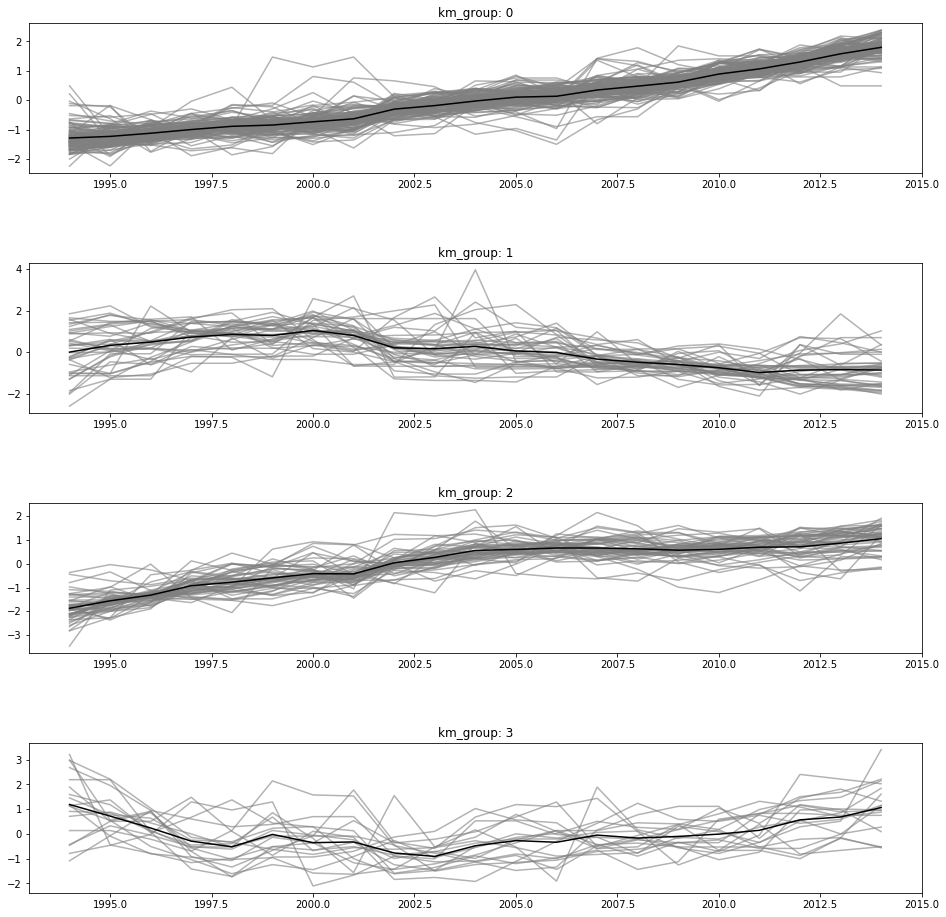

In [394]:
# Shows Results from K-Means clustering
plot_clusters("km_group", 4)

### Figure 1

This is a time-series chart based on k-mean clustering. Each Time Series shows distinct trends as we expect. For example, both cluster 0 and 2 suggests steady growth in business establishment, but different intensity. Cluster 1 and 3 shows declines and fluctuation in growh, but differ by phase.

In [395]:
# Join clustering labels back to original dataset
geo_cluster = join_df.merge(whiten_df[['km_group', 'agc_group']], 
                            left_on ="ZIPCODE", right_index= True)


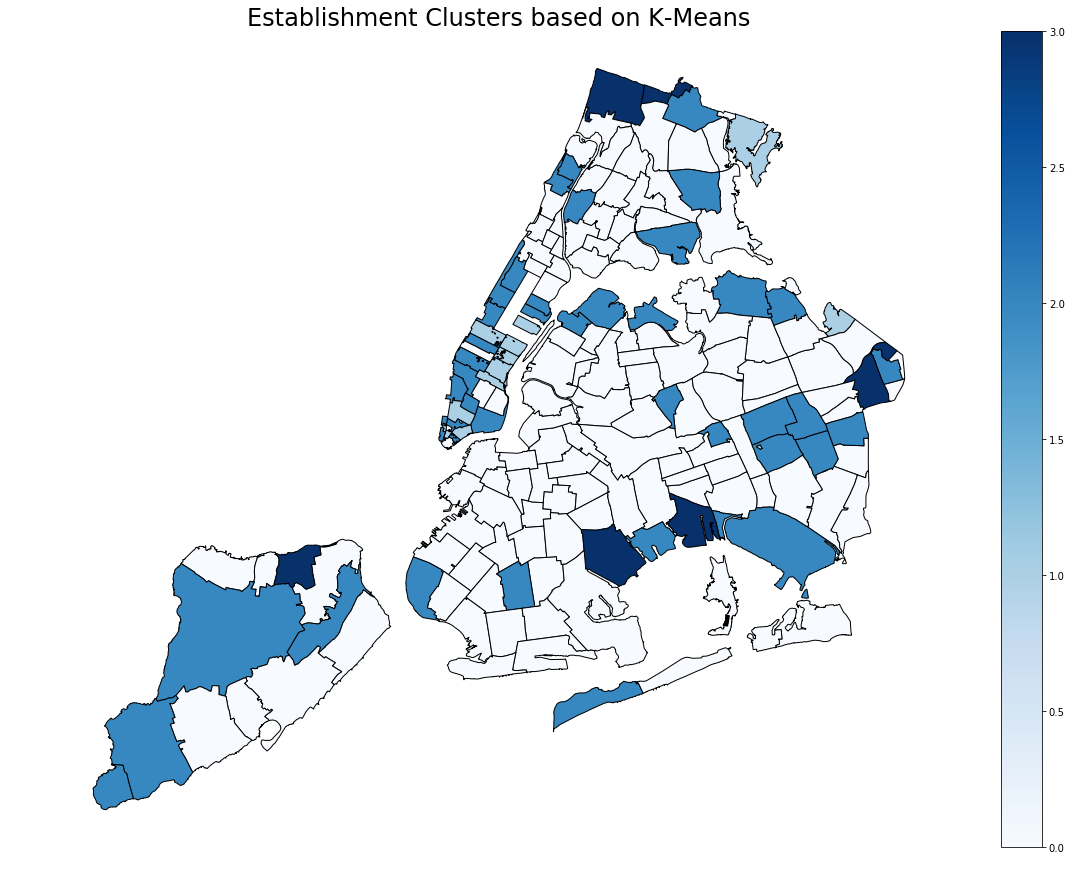

In [396]:
fig = plt.figure(figsize = (20, 15))
ax = fig.add_subplot(111)

geo_cluster.plot(ax = ax, column = "km_group", cmap = "Blues", 
                 edgecolor='k', lw=1, legend=True);
ax.set_title("Establishment Clusters based on K-Means", size = 24);
ax.axis('off');

### Figure 3

This is a geo-spatial map highlighting different clusters of establishment overtime usin k-means. Based on the cluster charateristic in Figure 1, most areas experience a steady increase in establishment. However, some areas such as upper east / west side, parts of lower Manhattan, and Western Staten Island experienced some decline. 

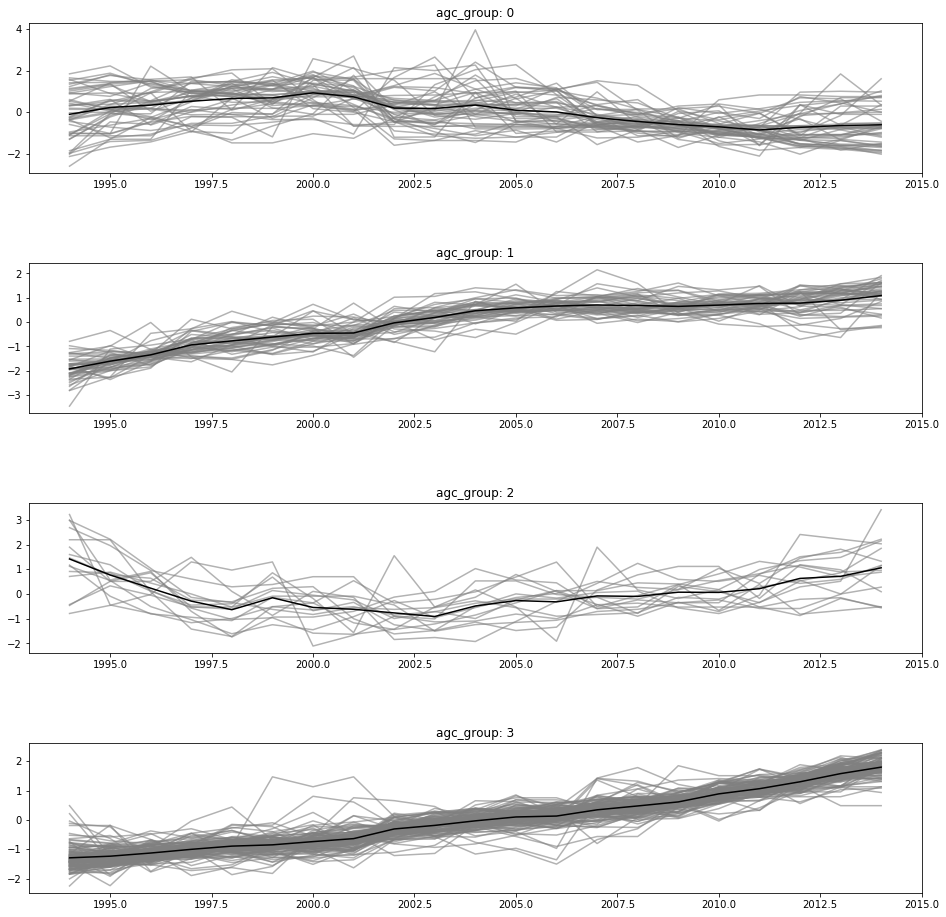

In [398]:
# Plot the clustering results from Agglomerative Clustering
plot_clusters("agc_group", 4)

### Figure 3

This is a time-series chart based on Agglomerative Clustering. The pattern in clusters are very similar to k-means, but the labeling order is different.

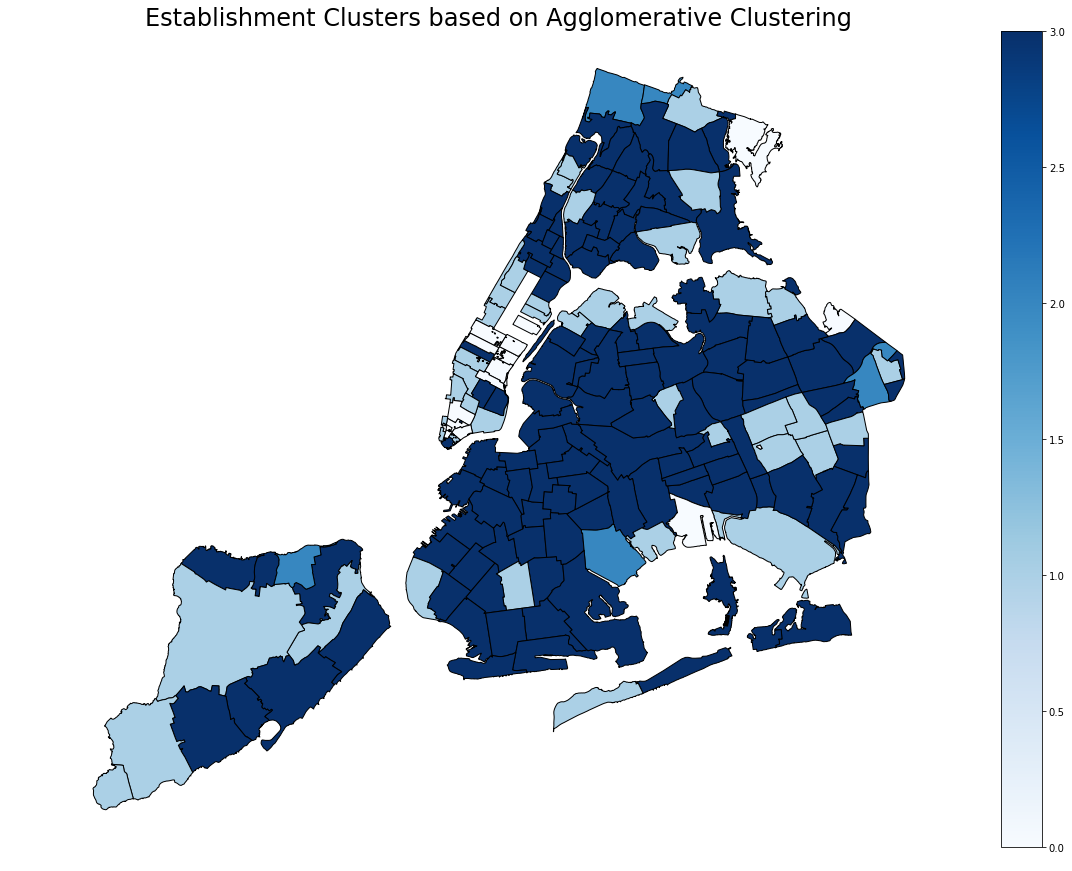

In [399]:
fig = plt.figure(figsize = (20, 15))
ax = fig.add_subplot(111)

geo_cluster.plot(ax = ax, column = "agc_group", cmap = "Blues", 
                 edgecolor='k', lw=1, legend=True);
ax.set_title("Establishment Clusters based on Agglomerative Clustering", size = 24);
ax.axis('off');

### Figure 4¶
This is a geo-spatial map highlighting different clusters of establishment overtime using Agglomerative Clustering. Although the labeling order is different, but the pattern and insights are very similar to the k-means. 

---

## 5. Interpretation and Analysis

Based on the k-means approach, here are the high level cluster patterns: 

- **cluster 0**: steady with a slight with strong momentum
- **cluster 1**: steady decline with some harsh drops in 2000 and 2004
- **cluster 2**: steady growth with a slight slow down
- **cluster 3**: steady growth till 2004 with a bounce back in 2011

Looking at cluster 2 based on the graph below, which is an interesting parttern, it suggests lower Manhattan and some parts in mid-town experienced long term decline with sharp drops in 2000 and 2004. These may due to the 9.11 event and also increasing gap in supply-demand of office real estates. 

In addition, upper Bronx and some parts in Queen also experience the same pattern. This needs more investigation into the local policies and events.  

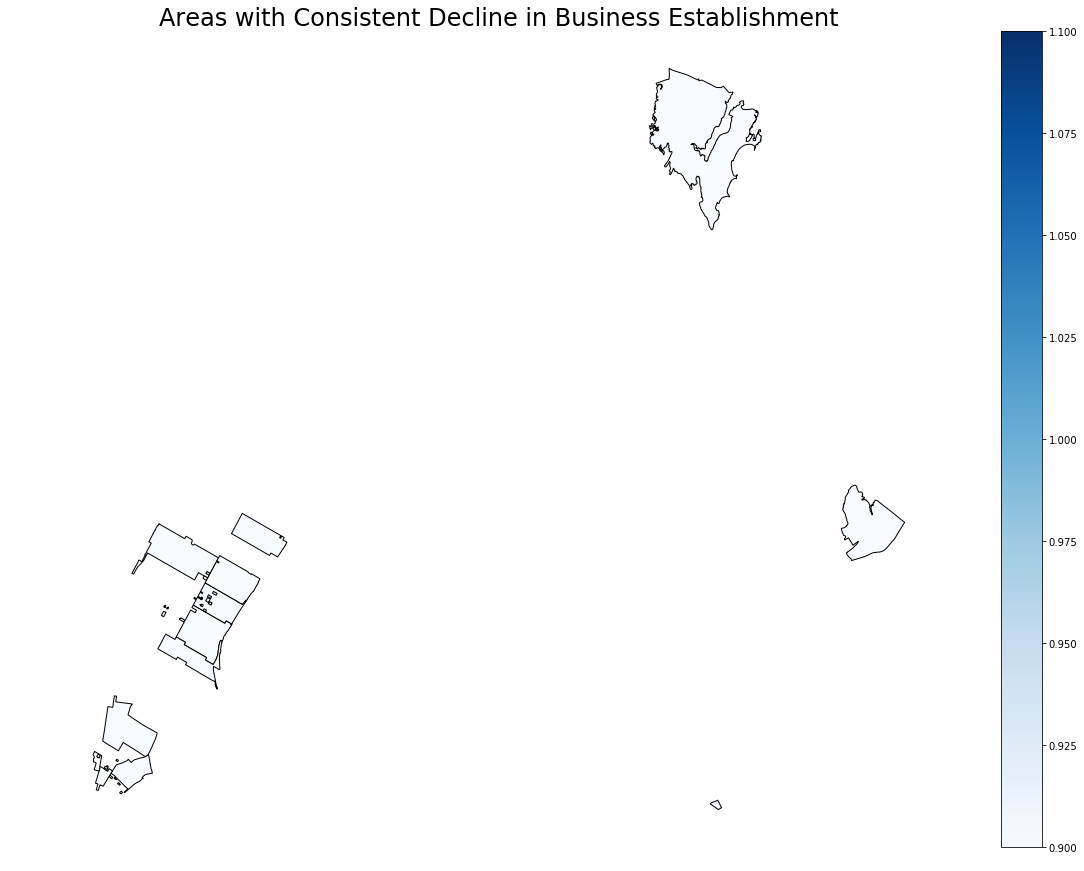

In [401]:
fig = plt.figure(figsize = (20, 15))
ax = fig.add_subplot(111)

geo_cluster[geo_cluster.km_group ==1].plot(ax = ax, column = "km_group", cmap = "Blues", 
                 edgecolor='k', lw=1, legend=True);
ax.set_title("Areas with Consistent Decline in Business Establishment", size = 24);
ax.axis('off');

### Figure 5

Geo-spatial plot of areas that belong to cluster 1 based on K-Means. These areas experienced very long term decline in business establishment with sharp drops in 2000 and 2004.